# Тема: Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st

import missingno as msno

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.simplefilter('ignore')

In [24]:
train = pd.read_csv('../data/assignment2_data/train.csv')
test = pd.read_csv('../data/assignment2_data/test.csv')

In [25]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [26]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 279.29 MB
Decreased by 48.4%


In [27]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 300.60 MB
Memory usage after optimization is: 155.16 MB
Decreased by 48.4%


In [28]:
def basic_analysis(data, data_name):
    
    stata.loc['Количество наблюдений', data_name] = data.shape[0]
    stata.loc['Количество признаков', data_name] = data.shape[1]
    
    for k, v in data.dtypes.value_counts().items():
        stata.loc[f'Признаков {k}', data_name] = v
        
    list_nan = [i for i in data.count() if i != data.shape[0]]
    stata.loc[f'Признаков с NaN', data_name] = len(list_nan)
    
    dict_num = {'disc': 0, 'cont': 0}
    for i in data.columns:
        if data[i].dtype != 'object':
            if data[i].nunique() < 25:
                dict_num['disc'] += 1
            else:
                dict_num['cont'] += 1          
    stata.loc[f'Дискретных признаков', data_name] = dict_num['disc']
    stata.loc[f'Непрерывных признаков', data_name] = dict_num['cont']

In [29]:
stata = pd.DataFrame(columns=['train', 'test'])

basic_analysis(data=train, data_name='train')
basic_analysis(data=test, data_name='test')

stata

,train,test
Количество наблюдений,180000,100001
Количество признаков,394,394
Признаков float32,376,376
Признаков object,14,14
Признаков int32,2,2
Признаков int16,1,1
Признаков int8,1,1
Признаков с NaN,319,299
Дискретных признаков,186,230
Непрерывных признаков,194,150


In [30]:
train.isFraud.value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

### Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [9]:
pd.options.display.max_columns = 380

In [31]:
target = train['isFraud']
num_features = train.select_dtypes(include=[np.number])
num_features = num_features.drop(['isFraud', 'TransactionID'], axis=1)
num_features.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [32]:
X_train_num, X_valid_num = train_test_split(num_features, train_size=0.8, random_state=1)
y_train_num, y_valid_num = train_test_split(target, train_size=0.8, random_state=1)

X_train_num.shape, X_valid_num.shape, y_train_num.shape, y_valid_num.shape

((144000, 378), (36000, 378), (144000,), (36000,))

In [33]:
params_xgb = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 300,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [34]:
%%time 

model_xgb_num = xgb.XGBClassifier(**params_xgb)

model_xgb_num.fit(X=X_train_num, y=y_train_num,
            eval_set=[(X_train_num, y_train_num), (X_valid_num, y_valid_num)], 
            early_stopping_rounds=50,
            eval_metric="auc",
            verbose=20)

[0]	validation_0-auc:0.64988	validation_1-auc:0.65040
[20]	validation_0-auc:0.83706	validation_1-auc:0.83095
[40]	validation_0-auc:0.87409	validation_1-auc:0.86766
[60]	validation_0-auc:0.88911	validation_1-auc:0.88097
[80]	validation_0-auc:0.89578	validation_1-auc:0.88621
[100]	validation_0-auc:0.90013	validation_1-auc:0.88967
[120]	validation_0-auc:0.90431	validation_1-auc:0.89360
[140]	validation_0-auc:0.90705	validation_1-auc:0.89655
[160]	validation_0-auc:0.90953	validation_1-auc:0.89858
[180]	validation_0-auc:0.91004	validation_1-auc:0.89892
[200]	validation_0-auc:0.91004	validation_1-auc:0.89892
[217]	validation_0-auc:0.91004	validation_1-auc:0.89892
CPU times: user 3min 36s, sys: 490 ms, total: 3min 36s
Wall time: 35.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [35]:
obj_features = train.select_dtypes(include=[np.object])
obj_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [36]:
for i in obj_features.columns:
    print(i, obj_features[i].nunique())

ProductCD 5
card4 4
card6 4
P_emaildomain 59
R_emaildomain 60
M1 2
M2 2
M3 2
M4 3
M5 2
M6 2
M7 2
M8 2
M9 2


<AxesSubplot:>

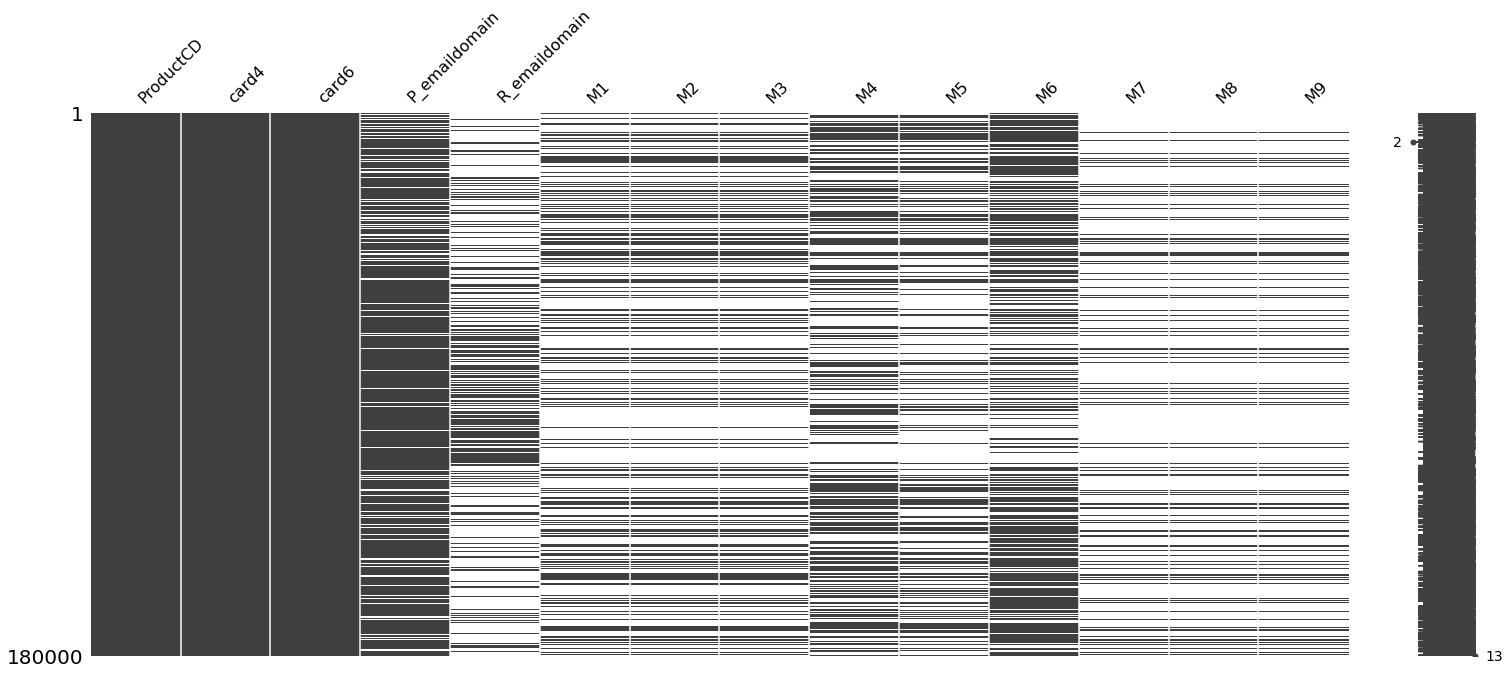

In [37]:
msno.matrix(obj_features)

In [38]:
obj_dum_features = obj_features.copy()

obj_dum_features.loc[obj_dum_features['P_emaildomain'].notnull(), 'P_emaildomain'] = 1
obj_dum_features.loc[obj_dum_features['R_emaildomain'].notnull(), 'R_emaildomain'] = 1

obj_dum_features = pd.get_dummies(obj_dum_features, dummy_na=True)
obj_dum_features.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card4_nan,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_nan,P_emaildomain_1.0,P_emaildomain_nan,R_emaildomain_1.0,R_emaildomain_nan,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1


In [39]:
num_obj_features = pd.merge(num_features, obj_dum_features, how ='inner', on=num_features.index)
num_obj_features.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,...,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card4_nan,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_nan,P_emaildomain_1.0,P_emaildomain_nan,R_emaildomain_1.0,R_emaildomain_nan,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [40]:
X_train_num_obj, X_valid_num_obj = train_test_split(num_obj_features, train_size=0.8, random_state=1)
y_train_num_obj, y_valid_num_obj = train_test_split(target, train_size=0.8, random_state=1)

X_train_num_obj.shape, X_valid_num_obj.shape, y_train_num_obj.shape, y_valid_num_obj.shape

((144000, 427), (36000, 427), (144000,), (36000,))

In [41]:
%%time

model_xgb_num_obj = xgb.XGBClassifier(**params_xgb)

model_xgb_num_obj.fit(X=X_train_num_obj, y=y_train_num_obj,
            eval_set=[(X_train_num_obj, y_train_num_obj), (X_valid_num_obj, y_valid_num_obj)], 
            early_stopping_rounds=50,
            eval_metric="auc",
            verbose=20)

[0]	validation_0-auc:0.64988	validation_1-auc:0.65040
[20]	validation_0-auc:0.83706	validation_1-auc:0.83095
[40]	validation_0-auc:0.87620	validation_1-auc:0.86967
[60]	validation_0-auc:0.89471	validation_1-auc:0.88544
[80]	validation_0-auc:0.90289	validation_1-auc:0.89262
[100]	validation_0-auc:0.90814	validation_1-auc:0.89655
[120]	validation_0-auc:0.91221	validation_1-auc:0.89974
[140]	validation_0-auc:0.91498	validation_1-auc:0.90248
[160]	validation_0-auc:0.91545	validation_1-auc:0.90284
[180]	validation_0-auc:0.91545	validation_1-auc:0.90284
[194]	validation_0-auc:0.91545	validation_1-auc:0.90284
CPU times: user 3min 34s, sys: 583 ms, total: 3min 34s
Wall time: 35.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [65]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 4000,
    "n_jobs": 6,
    "seed": 27
}

In [66]:
%%time

model_lgb_num = lgb.LGBMClassifier(**params_lgb)

model_lgb_num.fit(X=X_train_num, y=y_train_num,
            eval_set=[(X_train_num, y_train_num), (X_valid_num, y_valid_num)],
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=200)

Training until validation scores don't improve for 25 rounds
[200]	training's auc: 0.911502	valid_1's auc: 0.893902
[400]	training's auc: 0.937203	valid_1's auc: 0.913587
[600]	training's auc: 0.9522	valid_1's auc: 0.924631
[800]	training's auc: 0.960794	valid_1's auc: 0.930532
[1000]	training's auc: 0.967635	valid_1's auc: 0.934938
[1200]	training's auc: 0.972386	valid_1's auc: 0.937767
[1400]	training's auc: 0.976275	valid_1's auc: 0.939964
[1600]	training's auc: 0.979513	valid_1's auc: 0.942149
[1800]	training's auc: 0.982105	valid_1's auc: 0.943812
[2000]	training's auc: 0.984792	valid_1's auc: 0.945645
[2200]	training's auc: 0.986526	valid_1's auc: 0.947075
[2400]	training's auc: 0.988288	valid_1's auc: 0.948048
[2600]	training's auc: 0.989594	valid_1's auc: 0.949103
[2800]	training's auc: 0.990754	valid_1's auc: 0.949718
[3000]	training's auc: 0.991755	valid_1's auc: 0.950673
[3200]	training's auc: 0.992661	valid_1's auc: 0.951134
Early stopping, best iteration is:
[3290]	trainin

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=4000, n_jobs=6,
               objective='binary', seed=27)

### Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [67]:
%%time

model_lgb_num_obj = lgb.LGBMClassifier(**params_lgb)

model_lgb_num_obj.fit(X=X_train_num_obj, y=y_train_num_obj,
            eval_set=[(X_train_num_obj, y_train_num_obj), (X_valid_num_obj, y_valid_num_obj)],
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=200)

Training until validation scores don't improve for 25 rounds
[200]	training's auc: 0.914622	valid_1's auc: 0.900575
[400]	training's auc: 0.942889	valid_1's auc: 0.920992
[600]	training's auc: 0.95771	valid_1's auc: 0.932039
[800]	training's auc: 0.965644	valid_1's auc: 0.937399
[1000]	training's auc: 0.972309	valid_1's auc: 0.940874
[1200]	training's auc: 0.976987	valid_1's auc: 0.943332
[1400]	training's auc: 0.980483	valid_1's auc: 0.945362
[1600]	training's auc: 0.983869	valid_1's auc: 0.947356
[1800]	training's auc: 0.986358	valid_1's auc: 0.948908
[2000]	training's auc: 0.988342	valid_1's auc: 0.949972
[2200]	training's auc: 0.989885	valid_1's auc: 0.950955
[2400]	training's auc: 0.991237	valid_1's auc: 0.95181
[2600]	training's auc: 0.992616	valid_1's auc: 0.952492
[2800]	training's auc: 0.993589	valid_1's auc: 0.953162
Early stopping, best iteration is:
[2807]	training's auc: 0.993611	valid_1's auc: 0.953178
CPU times: user 7min 43s, sys: 2.05 s, total: 7min 45s
Wall time: 1min

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=4000, n_jobs=6,
               objective='binary', seed=27)

### Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [68]:
cat_features = obj_features.astype('category')
cat_features.head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,nan,nan,T,T,T,M2,F,T,nan,nan,nan
1,W,mastercard,credit,gmail.com,nan,nan,nan,nan,M0,T,T,nan,nan,nan


In [69]:
num_cat_features = pd.merge(num_features, cat_features, how ='inner', on=num_features.index)
num_cat_features.head(2)

,key_0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,...,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,discover,credit,nan,nan,T,T,T,M2,F,T,nan,nan,nan
1,1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

In [70]:
cat_features_name = list(cat_features.columns)
cat_features_name

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [71]:
X_train_num_cat, X_valid_num_cat = train_test_split(num_cat_features, train_size=0.8, random_state=1)
y_train_num_cat, y_valid_num_cat = train_test_split(target, train_size=0.8, random_state=1)

X_train_num_cat.shape, X_valid_num_cat.shape, y_train_num_cat.shape, y_valid_num_cat.shape

((144000, 393), (36000, 393), (144000,), (36000,))

In [72]:
%%time

model_lgb_num_cat = lgb.LGBMClassifier(**params_lgb)

model_lgb_num_cat.fit(X=X_train_num_cat, y=y_train_num_cat,
            eval_set=[(X_train_num_cat, y_train_num_cat), (X_valid_num_cat, y_valid_num_cat)],
            categorical_feature="auto",
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=200)

Training until validation scores don't improve for 25 rounds
[200]	training's auc: 0.920074	valid_1's auc: 0.905033
[400]	training's auc: 0.947665	valid_1's auc: 0.924151
[600]	training's auc: 0.961109	valid_1's auc: 0.933823
[800]	training's auc: 0.968407	valid_1's auc: 0.938738
[1000]	training's auc: 0.975081	valid_1's auc: 0.942199
[1200]	training's auc: 0.979842	valid_1's auc: 0.944482
[1400]	training's auc: 0.983463	valid_1's auc: 0.946436
[1600]	training's auc: 0.986223	valid_1's auc: 0.948101
[1800]	training's auc: 0.988414	valid_1's auc: 0.949538
[2000]	training's auc: 0.990158	valid_1's auc: 0.950869
[2200]	training's auc: 0.991675	valid_1's auc: 0.952134
[2400]	training's auc: 0.99282	valid_1's auc: 0.952944
[2600]	training's auc: 0.993753	valid_1's auc: 0.953569
[2800]	training's auc: 0.994622	valid_1's auc: 0.95432
[3000]	training's auc: 0.995344	valid_1's auc: 0.954893
[3200]	training's auc: 0.996172	valid_1's auc: 0.955315
Early stopping, best iteration is:
[3256]	trainin

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=4000, n_jobs=6,
               objective='binary', seed=27)

**Вывод:**
* Качество моделей LGBMClassifier на предобработанных вручную и встроенным методом категориальных параметрах отличается несущественно.

### Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [73]:
params_cb = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [74]:
%%time

model_cb_num = cb.CatBoostClassifier(**params_cb)

model_cb_num.fit(X_train_num, y_train_num, 
                 eval_set=[(X_train_num, y_train_num), (X_valid_num, y_valid_num)])

0:	test: 0.5902680	test1: 0.5988007	best: 0.5988007 (0)	total: 94.2ms	remaining: 15m 41s
500:	test: 0.8943697	test1: 0.8851638	best: 0.8851638 (500)	total: 26.9s	remaining: 8m 29s
1000:	test: 0.8973979	test1: 0.8876637	best: 0.8876637 (1000)	total: 51.6s	remaining: 7m 43s
1500:	test: 0.9033225	test1: 0.8924259	best: 0.8924259 (1500)	total: 1m 16s	remaining: 7m 15s
2000:	test: 0.9094267	test1: 0.8979253	best: 0.8979253 (2000)	total: 1m 42s	remaining: 6m 49s
2500:	test: 0.9144179	test1: 0.9023408	best: 0.9023408 (2500)	total: 2m 7s	remaining: 6m 23s
3000:	test: 0.9185548	test1: 0.9057954	best: 0.9057954 (3000)	total: 2m 32s	remaining: 5m 56s
3500:	test: 0.9218121	test1: 0.9081866	best: 0.9082028 (3498)	total: 2m 57s	remaining: 5m 29s
4000:	test: 0.9244651	test1: 0.9103805	best: 0.9103805 (4000)	total: 3m 21s	remaining: 5m 2s
4500:	test: 0.9271607	test1: 0.9126302	best: 0.9126304 (4499)	total: 3m 46s	remaining: 4m 37s
5000:	test: 0.9297252	test1: 0.9142576	best: 0.9142576 (5000)	total: 4m

### Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [75]:
%%time 

model_cb_num_obj = cb.CatBoostClassifier(**params_cb)

model_cb_num_obj.fit(X_train_num_obj, y_train_num_obj, 
                     eval_set=[(X_train_num_obj, y_train_num_obj), (X_valid_num_obj, y_valid_num_obj)])

0:	test: 0.5936783	test1: 0.6031184	best: 0.6031184 (0)	total: 48.1ms	remaining: 8m 1s
500:	test: 0.8999958	test1: 0.8904362	best: 0.8904362 (500)	total: 27.6s	remaining: 8m 43s
1000:	test: 0.9039380	test1: 0.8936365	best: 0.8936380 (993)	total: 53.1s	remaining: 7m 57s
1500:	test: 0.9105642	test1: 0.8993894	best: 0.8993894 (1500)	total: 1m 18s	remaining: 7m 25s
2000:	test: 0.9162119	test1: 0.9041894	best: 0.9041894 (2000)	total: 1m 44s	remaining: 6m 58s
2500:	test: 0.9218954	test1: 0.9088666	best: 0.9088666 (2500)	total: 2m 11s	remaining: 6m 34s
3000:	test: 0.9256943	test1: 0.9116948	best: 0.9116952 (2997)	total: 2m 37s	remaining: 6m 7s
3500:	test: 0.9286325	test1: 0.9137280	best: 0.9137280 (3500)	total: 3m 2s	remaining: 5m 38s
4000:	test: 0.9316269	test1: 0.9155939	best: 0.9155941 (3999)	total: 3m 27s	remaining: 5m 11s
4500:	test: 0.9344976	test1: 0.9176063	best: 0.9176157 (4498)	total: 3m 53s	remaining: 4m 45s
5000:	test: 0.9365490	test1: 0.9189332	best: 0.9189332 (5000)	total: 4m 19

### Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [76]:
%%time 

model_cb_num_cat = cb.CatBoostClassifier(cat_features=cat_features_name, 
                              **params_cb)

model_cb_num_cat.fit(X_train_num_cat, y_train_num_cat, 
          eval_set=[(X_train_num_cat, y_train_num_cat), (X_valid_num_cat, y_valid_num_cat)])

0:	test: 0.6042633	test1: 0.6048554	best: 0.6048554 (0)	total: 167ms	remaining: 27m 49s
500:	test: 0.9026658	test1: 0.8926211	best: 0.8926211 (500)	total: 1m 25s	remaining: 27m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.89304001
bestIteration = 567

Shrink model to first 568 iterations.
CPU times: user 10min 9s, sys: 15.3 s, total: 10min 24s
Wall time: 1min 47s


**Вывод:**
Качество и количество итераций моделей CatBoostClassifier на предобработанных вручную и встроенным методом категориальных параметрах отличается существенно.

### Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

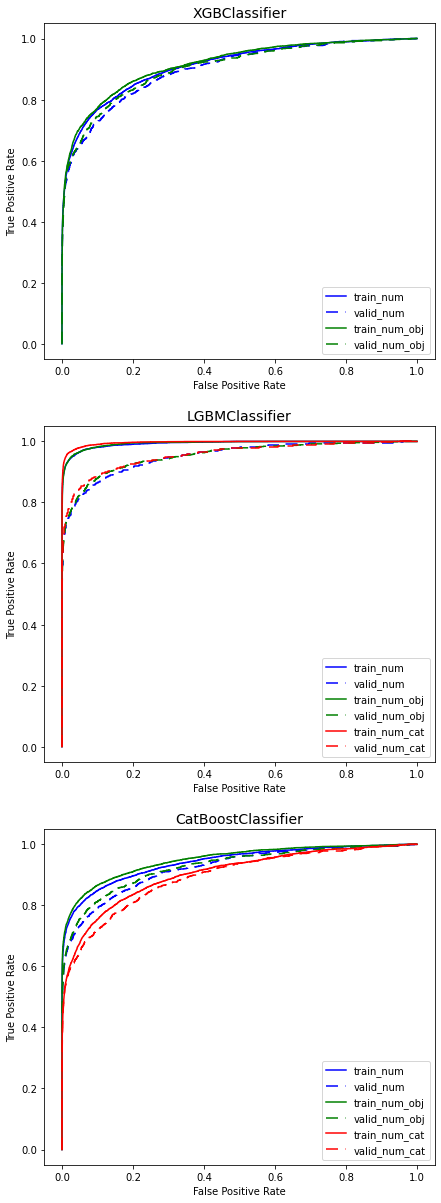

In [124]:
fig, axes = plt.subplots(3, 1, figsize=(7, 21))

axes[0].set_title("XGBClassifier", fontsize=14)
plot_roc_curve(model_xgb_num, X_train_num, y_train_num, ax=axes[0], label='train_num', c='b')
plot_roc_curve(model_xgb_num, X_valid_num, y_valid_num, ax=axes[0], label='valid_num', c='b', dashes=[8, 5])
plot_roc_curve(model_xgb_num_obj, X_train_num_obj, y_train_num_obj, ax=axes[0], label='train_num_obj', c='g')
plot_roc_curve(model_xgb_num_obj, X_valid_num_obj, y_valid_num_obj, ax=axes[0], label='valid_num_obj', c='g', dashes=[8, 5])

axes[1].set_title("LGBMClassifier", fontsize=14)
plot_roc_curve(model_lgb_num, X_train_num, y_train_num, ax=axes[1], label='train_num', c='b')
plot_roc_curve(model_lgb_num, X_valid_num, y_valid_num, ax=axes[1], label='valid_num', c='b', dashes=[8, 5])
plot_roc_curve(model_lgb_num_obj, X_train_num_obj, y_train_num_obj, ax=axes[1], label='train_num_obj', c='g')
plot_roc_curve(model_lgb_num_obj, X_valid_num_obj, y_valid_num_obj, ax=axes[1], label='valid_num_obj', c='g', dashes=[8, 5])
plot_roc_curve(model_lgb_num_cat, X_train_num_cat, y_train_num_cat, ax=axes[1], label='train_num_cat', c='r')
plot_roc_curve(model_lgb_num_cat, X_valid_num_cat, y_valid_num_cat, ax=axes[1], label='valid_num_cat', c='r', dashes=[8, 5])

axes[2].set_title("CatBoostClassifier", fontsize=14)
plot_roc_curve(model_cb_num, X_train_num, y_train_num, ax=axes[2], label='train_num', c='b')
plot_roc_curve(model_cb_num, X_valid_num, y_valid_num, ax=axes[2], label='valid_num', c='b', dashes=[8, 5])
plot_roc_curve(model_cb_num_obj, X_train_num_obj, y_train_num_obj, ax=axes[2], label='train_num_obj', c='g')
plot_roc_curve(model_cb_num_obj, X_valid_num_obj, y_valid_num_obj, ax=axes[2], label='valid_num_obj', c='g', dashes=[8, 5])
plot_roc_curve(model_cb_num_cat, X_train_num_cat, y_train_num_cat, ax=axes[2], label='train_num_cat', c='r')
plot_roc_curve(model_cb_num_cat, X_valid_num_cat, y_valid_num_cat, ax=axes[2], label='valid_num_cat', c='r', dashes=[8, 5])

**Вывод:**
* XGBClassifier - не самые высокие показатели на валидационных данных, но переобучение практически отсутствует, разница между типами входных данных несущественная.
* LGBMClassifier - самые высокие показатели на валидационных данных, но при этом самое высокое переобучение, разница между типами входных данных несущественная.
* CatBoostClassifier - самые низкие показатели на валидационных данных, досточно высокое переобучение, при обработке категориальных переменных механизмом модели показатели гораздо ниже.

## Задание на повторение:  
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

### Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

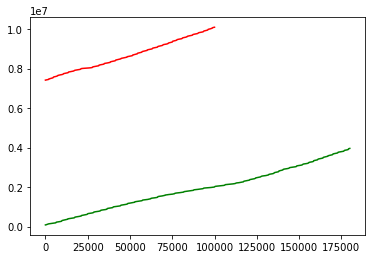

In [104]:
plt.plot(train.TransactionDT, c='g')
plt.plot(test.TransactionDT, c='r')

**Вывод:**  
* данные train и test разбиты с промежутком по времени

### Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

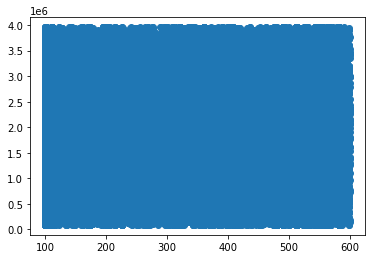

In [47]:
train_0 = train[train['isFraud']==0].copy()
plt.scatter(train_0.card2, train_0.TransactionDT)

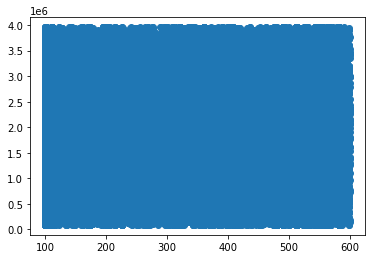

In [48]:
train_1 = train[train['isFraud']==1].copy()
plt.scatter(train_0.card2, train_0.TransactionDT)

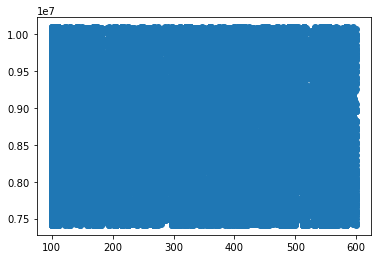

In [49]:
plt.scatter(test.card2, test.TransactionDT)

**Вывод:**  
* сумма и время совершения транзакции не являются линейнозависимыми признаками.

### Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

<AxesSubplot:xlabel='TransactionAmt', ylabel='Density'>

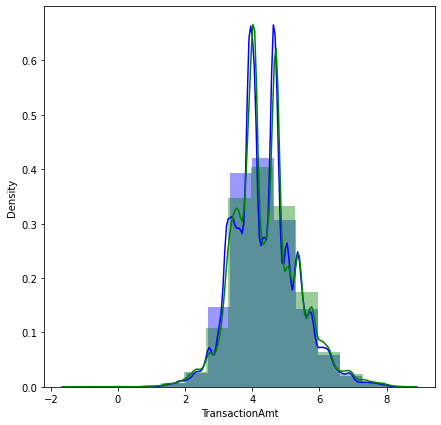

In [150]:
fig = plt.figure(figsize=(7, 7))
sns.distplot(np.log(train['TransactionAmt']), bins=15, color="blue")
sns.distplot(np.log(test['TransactionAmt']), bins=15, color="green")

**Вывод:**
* распределение признака TransactionAmt не распределена по нормальному распределению.

### Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

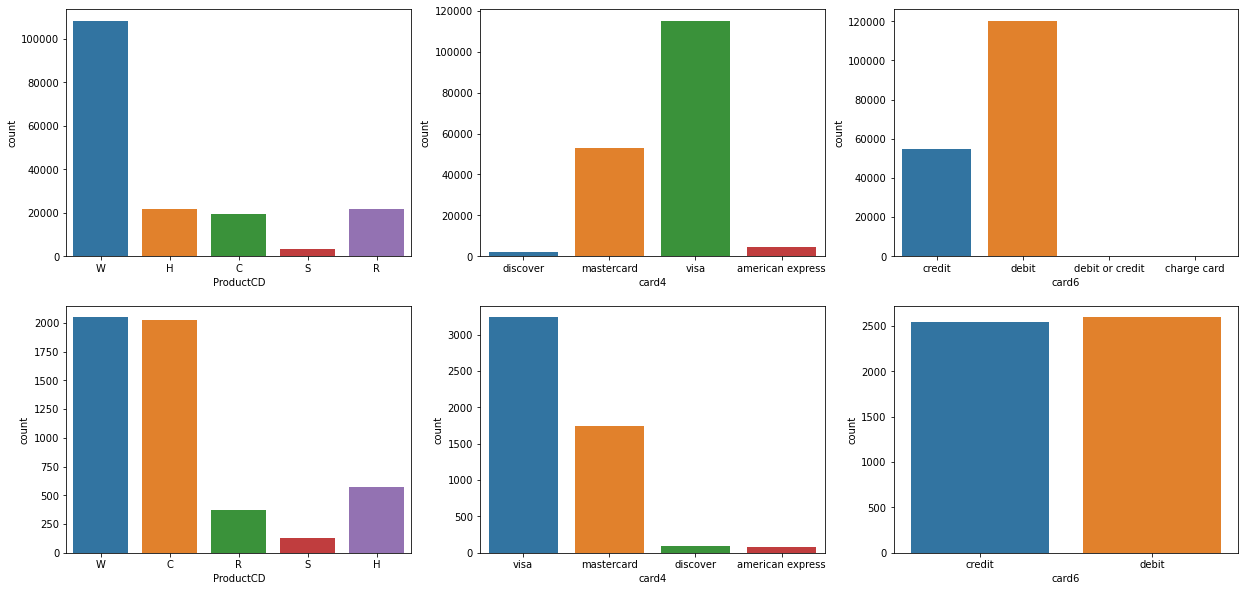

In [194]:
features = ['ProductCD', 'card4', 'card6']

fig, axes = plt.subplots(2, 3, figsize=(21, 10))

for num, feature in enumerate(features):
    data = train[[feature, 'isFraud']]
    data_target_0 = data[data['isFraud'] == 0]
    data_target_1 = data[data['isFraud'] == 1]
    sns.countplot(x=feature, data=data_target_0, ax=axes[0, num], label='target_0')
    sns.countplot(x=feature, data=data_target_1, ax=axes[1, num], label='target_1')
    
plt.show()

**Вывод:**
* ProductCD - похоже, что значение признака 'С' имеет линейную зависимость с целевой переменной
* card4 - распределение целевой переменной не зависит от значений признака
* card6 - целевая переменная чаще равна 0, если значение признака = 'debit'